In [0]:
!pip install pydrive

In [0]:
import numpy as np
import json
import pandas as pd

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
import tensorflow as tf
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_list = drive.ListFile({'q': "'1LYvb3OMwbKUgjViakvkHycYXSMpOx02x' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Team11_Boeing.json, id: 1oBUOiWS5AlapafCe80XsyW0yzRGDuROk
title: glove.6B.300d.txt, id: 1DBXDDm1cHVwqjoQpSpmc3Xn2w8bJhI81
title: glove.6B.200d.txt, id: 1SLw14eCap4C03Rh9_SpYbXGCXBTAtFw4
title: glove.6B.100d.txt, id: 1B-VAxihJke7NXxhSLoHkqBfqARQ5GFq6
title: glove.6B.50d.txt, id: 12OnMdsv07C1V4ZGvQ4prqr5joIGqOPEk


In [0]:
glove_file = drive.CreateFile({'id': '1B-VAxihJke7NXxhSLoHkqBfqARQ5GFq6'})
glove_file.GetContentFile('glove.6B.100d.txt')
json_file = drive.CreateFile({'id': '1oBUOiWS5AlapafCe80XsyW0yzRGDuROk'})
json_file.GetContentFile('Team11_Boeing.json')

In [0]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
import pandas as pd
import numpy as np
import itertools
from keras.preprocessing import text, sequence
from keras import utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [0]:
json_df=pd.read_json("Complete.json")

In [0]:
json_df['sentiment'].value_counts()

Neutral     750
Positive    561
Negative    143
Name: sentiment, dtype: int64

In [0]:
train_size = int(len(json_df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(json_df) - train_size))

Train size: 1163
Test size: 291


In [0]:
train_posts = json_df['text'][:train_size]
train_tags = json_df['sentiment'][:train_size]

test_posts = json_df['text'][train_size:]
test_tags = json_df['sentiment'][train_size:]

In [0]:
max_words = 245
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [0]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [0]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [0]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [0]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1163, 100)
x_test shape: (291, 100)
y_train shape: (1163, 3)
y_test shape: (291, 3)


In [0]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 26
epoch = 75

In [0]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=max_words))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(num_classes, activation='tanh'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=epoch,
                    batch_size=64,
                    validation_split=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 245, 8)            80000     
_________________________________________________________________
flatten_17 (Flatten)         (None, 1960)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 5883      
Total params: 85,883
Trainable params: 85,883
Non-trainable params: 0
_________________________________________________________________
Train on 930 samples, validate on 233 samples
Epoch 1/75
930/930 [==============================] - 1s 864us/step - loss: 3.1037 - acc: 0.6667 - val_loss: 3.2528 - val_acc: 0.6667
Epoch 2/75
930/930 [==============================] - 0s 80us/step - loss: 2.9845 - acc: 0.6667 - val_loss: 3.2304 - val_acc: 0.6667
Epoch 3/75
930/930 [==============================] - 0s 81us/step - loss: 2.9815 - acc: 

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

291/291 [==============================] - 0s 99us/step
Test score: 1.0067590102297335
Test accuracy: 0.7560137629099318


In [0]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

Thanks, Matt. Rob, next question please. ...
Actual label:Neutral
Predicted label: Neutral

The next question comes from the line of Kate McSh ...
Actual label:Positive
Predicted label: Neutral

Hi. Thank you for taking my question. Just to dril ...
Actual label:Neutral
Predicted label: Neutral

I think two questions. On your first question arou ...
Actual label:Positive
Predicted label: Positive

Can you walk us through what the overall apparel s ...
Actual label:Positive
Predicted label: Neutral

Sure. I'm excited about -- later this week, I'm he ...
Actual label:Positive
Predicted label: Positive

And we have some new fixturing in some stores that ...
Actual label:Neutral
Predicted label: Neutral

We've got a big apparel business. It has been grow ...
Actual label:Neutral
Predicted label: Positive

Online Grocery customers are a great example as th ...
Actual label:Positive
Predicted label: Positive

Thanks, Kate. Next question please. ...
Actual label:Neutral
Predicted label: Neutr

In [0]:
y_softmax = model.predict(x_train)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_train)):
    probs = y_train[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

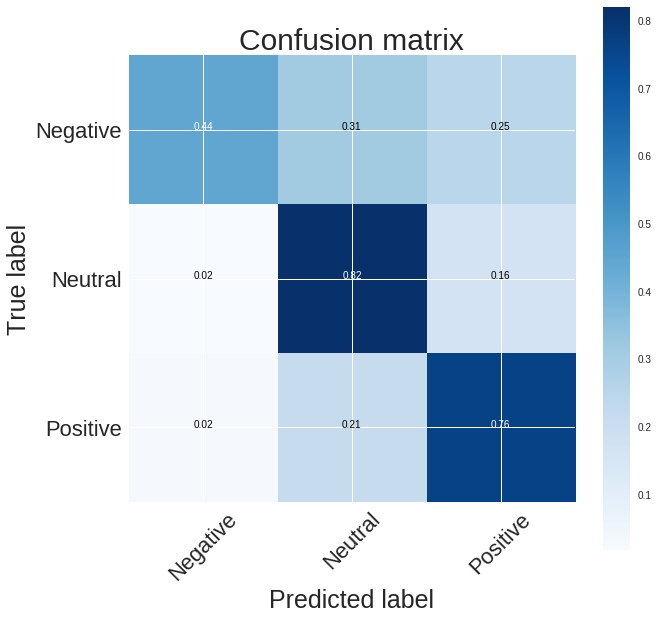

In [0]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
#cnf_matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [0]:
del x_test,x_train,y_train,y_test

In [0]:
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
maxLength = 20

x_train,x_test, y_train, y_test = train_test_split(text_df,sentiment_df,test_size=0.2)

#This turns our lists of integers
#into a 2D integer tensor of shape `(samples, maxlen)`
# x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxLength)
# x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxLength)

x_train

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
total_reviews = x_train.append(x_test)
x_test[1:,:]
#tokenizer_obj.fit_on_texts(total_reviews[])

In [0]:
ids = np.zeros((maxLength), dtype='int32')

In [0]:
def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [0]:

  cleanedLine = cleanSentences(line)
  split = cleanedLine.split()
  for word in split:
    try:
      ids[indexCounter] = wordsList.index(word)
    except ValueError:
           ids[indexCounter] = 399999 #Vector for unkown words
           indexCounter = indexCounter + 1
           if indexCounter >= maxSeqLength:
               break
np.save('ids_Matrix', ids)

In [0]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxLength))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
